# Metabolomics Case Study - Feature Annotation by Spectral Database Search
Jonathan E. Hunter, January 2025

In [1]:
### Import Python Libraries ###
# Import basic python data and plotting libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Import pyopenms and deps.    
from rdkit import Chem
from rdkit.Chem import Draw

# Import SimMS, MatchMS and deps
from matchms import calculate_scores
from matchms.importing import load_from_mgf
from matchms.filtering import require_correct_ionmode
from simms.similarity import CudaCosineGreedy  
from tensorflow.keras import backend as K

2025-02-04 14:19:27.547493: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738678767.562023     490 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738678767.566476     490 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-04 14:19:27.582785: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
## Test GPU environment.
gpu = ! nvidia-smi
print("\n".join(gpu))

Tue Feb  4 14:19:30 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.86.16              Driver Version: 572.16         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3090        On  |   00000000:0B:00.0  On |                  N/A |
|  0%   56C    P8             37W /  350W |   23636MiB /  24576MiB |     12%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
# Import query and reference spectra.
references = list(load_from_mgf("sync/Spectral_Databases/20250125_ALL_GNPS.mgf"))
queries = list(load_from_mgf("sync/Output/extract_MS2_spectra_FULL.mgf"))

# Filter GNPS database to only include positive ion mode spectra.
references_pos = []
for spectrum in references:
    spectrum = require_correct_ionmode(spectrum, ion_mode_to_keep='positive')
    if spectrum is not None:
        references_pos.append(spectrum)

In [4]:
# Define the similarity function.
similarity_function = CudaCosineGreedy(
    tolerance=0.001,  # Same parameters as CosineGreedy
    mz_power=0,
    intensity_power=1,
    shift=0,
    ## CUDA-specific parameters!
    ## Controls the number of reference/queries to process in one step
    # larger batch sizes might speed up processing if GPU has enough memory
    batch_size=800,
    # We need to trim any spectra with many peaks to maximum of `n_max_peaks`
    # shorter spectra aren't affected.
    n_max_peaks=1024,
    # Match limit is the number of possible pairs we accumulate before peak deduplication
    # In practice, match limits over 2k have negligible accuracy improvement.
    match_limit=2048,
    # Only used when array_type is 'sparse'. With sparse, we discard all scores
    # that are smaller than `sparse_threshold`. This allows us to save RAM memory
    # from overflowing when processing pairs on the order of ~1e+10.
    sparse_threshold=0.75,
)

# Calculate scores, spectra matching.
spectrum_scores = calculate_scores(                     
  references=references_pos,
  queries=queries,
  similarity_function=similarity_function, 
)

In [5]:
# Filter for precursor m/z matches within +-0.001
pc_matched = []

for query in queries:
    scores_output = spectrum_scores.scores_by_query(query, name="CudaCosineGreedy_score", sort=True)[:]
    for hit in scores_output:
        ref_pc_mz = np.round(hit[0].get("precursor_mz"), 6)       
        q_pc_mz = np.round(query.get("precursor_mz"), 6)
        if (ref_pc_mz >= q_pc_mz - 0.001) & (ref_pc_mz <= q_pc_mz + 0.001):
            pc_matched.append([hit, query])
        else:
            pass

In [6]:
# Extract the relevant information from the precursor+spectra matched hits.
results_assigned = []
for (hit, score), query in pc_matched:
    results_assigned.append({
        "Query feature ID": query.metadata['feature_id'],
        "Query scan id": query.metadata['scans'],
        "Reference scan id": hit.metadata['scans'],
        "Query precursor m/z": query.metadata['precursor_mz'],
        "Reference precursor_mz": hit.get("precursor_mz"),  
        "Score": score[0],
        "Number of matching peaks": score[1],
        "name": hit.get("compound_name"),
        "smiles": hit.get("smiles"),
        "charge": hit.get("charge"),
        "ms_level": hit.get("ms_level"),
        "Did GPU overflow": score[2]
    })

# Convert the results to a pandas DataFrame.
results_assigned_df = pd.DataFrame(results_assigned)

In [7]:
# Drop hits below a score of 80%
results_assigned_df_80 = results_assigned_df[results_assigned_df["Score"] >= 0.80]

In [8]:
FT2096 = []

# Find the target compound in the results data.
for (hit, score), query in pc_matched:
    if query.metadata['feature_id'] == "FT2096":
        FT2096.append([[hit, score], query])
    else:
        pass
    
# Display some summary information for the target compound hits.
print(f"{len(FT2096)} hits found for FT2096")   
print("Precursor m/z:", FT2096[0][1].metadata['precursor_mz'])
print("MS2 RT:", FT2096[0][1].metadata['retention_time'])

# Extract relevant information from the FT2096 hits.
FT2096_results = []
for (hit, score), query in FT2096:
    FT2096_results.append({
        "Query feature ID": query.metadata['feature_id'],
        "Query scan id": query.metadata['scans'],
        "Reference scan id": hit.metadata['scans'],
        "Query precursor m/z": query.metadata['precursor_mz'],
        "Reference precursor_mz": hit.get("precursor_mz"),  
        "Score": score[0],
        "Number of matching peaks": score[1],
        "name": hit.get("compound_name"),
        "smiles": hit.get("smiles"),
        "charge": hit.get("charge"),
        "ms_level": hit.get("ms_level"),
        "Did GPU overflow": score[2]
    })

# Convert the results to a pandas DataFrame.
FT2096_results_df = pd.DataFrame(FT2096_results)

# Drop hits below a score of 80%
FT2096_results_df_80 = FT2096_results_df[FT2096_results_df["Score"] >= 0.80]

# Display top 5 hits.
display(FT2096_results_df_80.head())

50 hits found for FT2096
Precursor m/z: 298.096650065991
MS2 RT: 329.738512463555


,Query feature ID,Query scan id,Reference scan id,Query precursor m/z,Reference precursor_mz,Score,Number of matching peaks,name,smiles,charge,ms_level,Did GPU overflow
0,FT2096,2049,16990,298.09665,298.097,0.998802,12,MeSAdo CollisionEnergy:205060 M+H,CSCC1OC(n2cnc3c(N)ncnc32)C(O)C1O,1,2,False
1,FT2096,2049,17216,298.09665,298.097,0.998731,12,Methylthioadenosine CollisionEnergy:205060 M+H,CSCC1OC(n2cnc3c(N)ncnc32)C(O)C1O,1,2,False
2,FT2096,2049,34428,298.09665,298.096,0.998082,12,Suspect related to Massbank:EQ330404 Adenosine...,None,1,2,False
3,FT2096,2049,40669,298.09665,298.097,0.997880,12,Methylthioadenosine [M+H]+,CSC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@...,1,2,False
4,FT2096,2049,7488,298.09665,298.097,0.997875,12,Methylthioadenosine M+H,CSC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@...,1,2,False


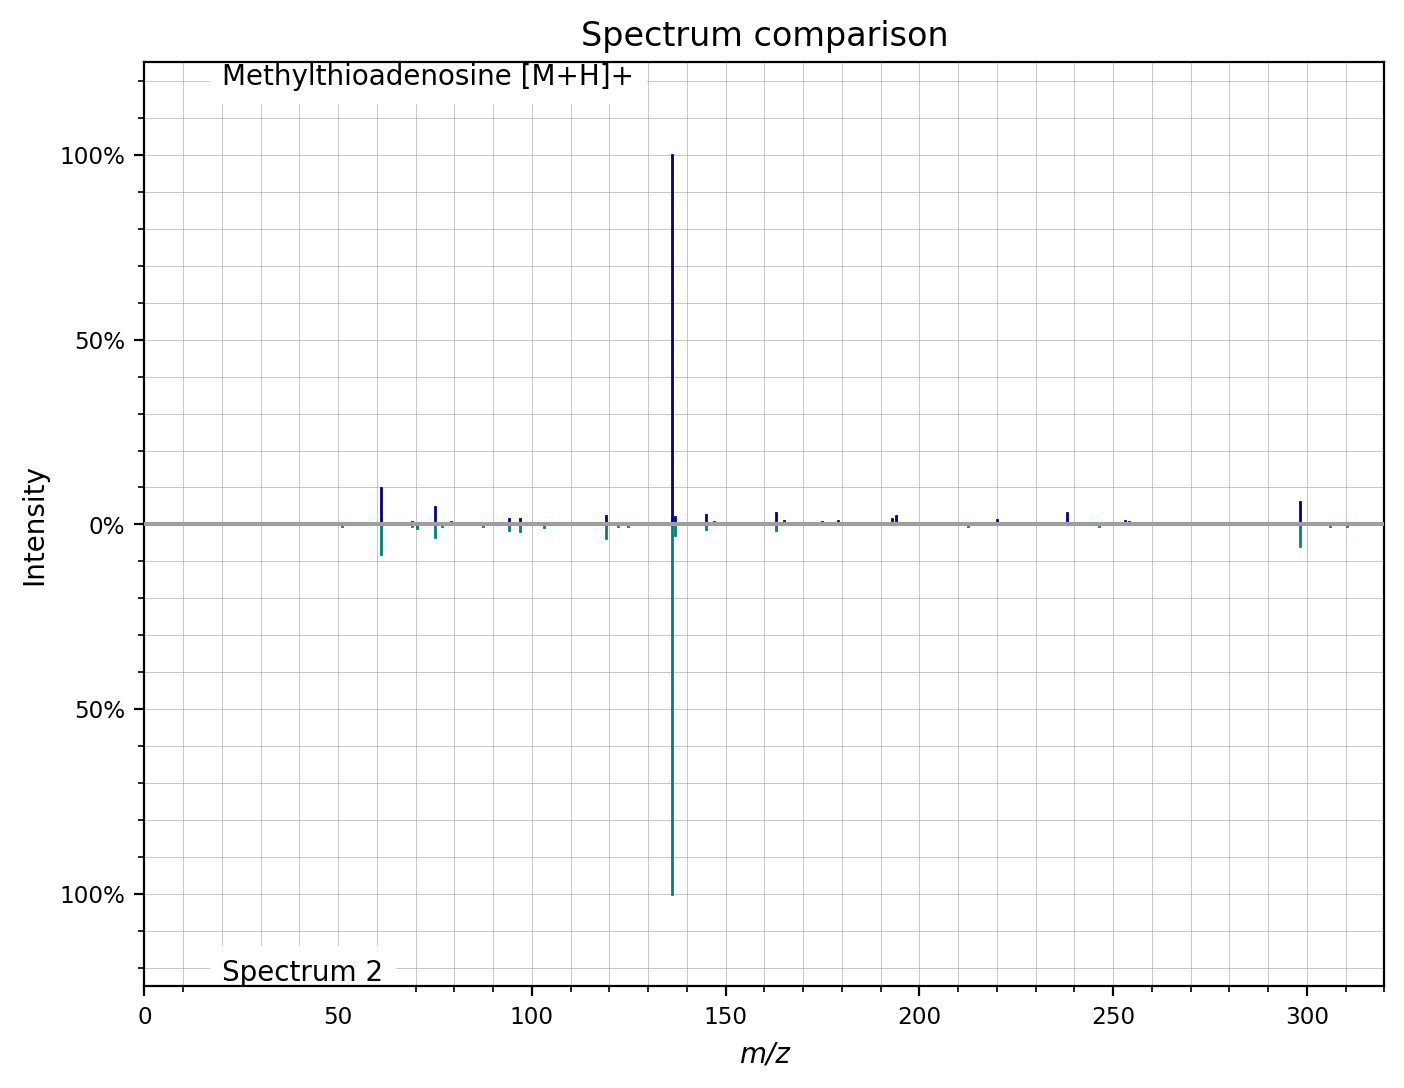

In [9]:
fig = FT2096[3][0][0].plot_against(FT2096[0][1], annotate_ions=True)
plt.xlim(0, 320)
plt.show()

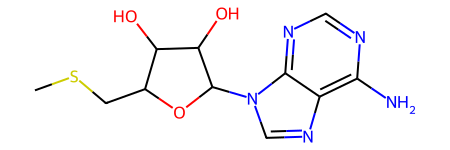

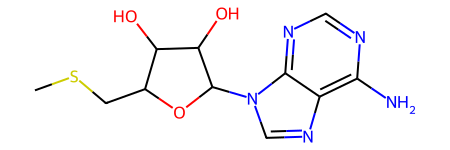

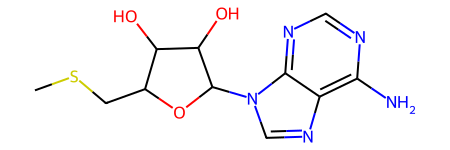

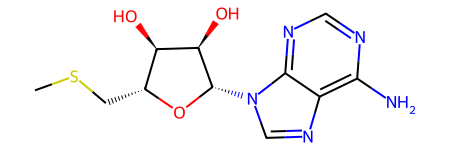

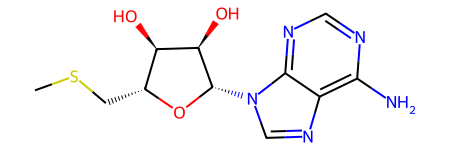

In [10]:
# Generate structures from the top 5 hits.
i = 0
for (hit, score), query in FT2096[:5]:
    smiles = (hit.get("smiles"))
    if smiles != None:
        m = Chem.MolFromSmiles(smiles)
        Draw.MolToFile(m, f"sync/Output/Structures/hit{i}.png")
    i += 1
    display(m)
    
    

In [11]:
## Summary statistics
print(f"Unique features with hits: {len(results_assigned_df_80["Query feature ID"].unique())}")
print(f"Median no. of spectral features matched: {results_assigned_df_80["Number of matching peaks"].median()}")


# Conservative parameters for this proof of concept:
# NeatMS High Quality peaks only.
# m/z match reqd within +- 0.001 on both precursor and fragment ions.
# Score threshold of >=0.80.


Unique features with hits: 95
Median no. of spectral features matched: 11.0
